In [1]:
import numpy as np 
import pandas as pd 
import datetime 
import pickle
import os
import time
import sys
import datetime

from RoZeroTools import infection_estimator
from RoZeroTools import ro_utils

%matplotlib inline
import matplotlib.pyplot as plt  
import seaborn as sns

In [2]:
def simple_smoother( s, window_size = 5):
    
    neg_idxs = [ i for i in range(len(s)) if s.iloc[i] < 0 ]
    if not neg_idxs:
        return s, False
    else:
        for i in neg_idxs:
            var_later = np.std(s.iloc[i+1:i+1+window_size].values )/ np.mean(s.iloc[i+1:i+1+window_size].values )
            var_earlier = np.std(s.iloc[i-window_size:i].values )/  np.mean(s.iloc[i-window_size:i].values )
            if var_later > var_earlier:  
                interval = (i, i+window_size+1) 
                tot = s.iloc[interval[0]: interval[1]].sum()
                s.iloc[i] = tot/ (window_size + 1)
                s.iloc[interval[0]+1:interval[1]] =(window_size/(window_size+1))*tot*( 
                                                        s.iloc[interval[0]+1:interval[1]]/(s.iloc[interval[0]+1:interval[1]].sum() ) )
            else:
                interval = (i - window_size, i+1 )
                tot = s.iloc[interval[0]: interval[1]].sum()
                s.iloc[i] = tot/ (window_size + 1)
                s.iloc[interval[0]:interval[1]-1] =(window_size/(window_size+1))*tot*( 
                                                        s.iloc[interval[0]:interval[1]-1]/(s.iloc[interval[0]:interval[1]-1].sum() ) )
        return s.astype(int), True

## Load data

In [4]:
JHU_deaths = ro_utils.load_JHU_deaths()
policies = pd.read_csv("../data/state_policy.csv" ,  header =0, index_col = 0) #.applymap(lambda x: pd.Timestamp(x))

## Identify states with greatest total casualties

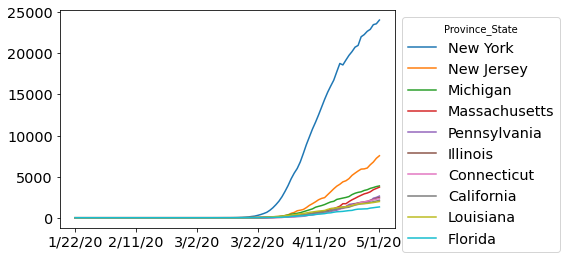

In [5]:
state_top_cas = list(JHU_deaths.iloc[:,-1].sort_values()[::-1].index[0:10])

ax = JHU_deaths.loc[state_top_cas, : ].transpose().plot()
leg = ax.get_legend()
leg.set_bbox_to_anchor( (1, 1), )

## Run smooter and plot number of deaths per day (scaled)

In [6]:
deaths_by_day = pd.DataFrame( index = pd.to_datetime(JHU_deaths.columns[1:]), columns = state_top_cas)
is_smoothed = pd.Series(index =state_top_cas, data = False, dtype = bool )

for state in state_top_cas:
    deaths_by_day_state =  JHU_deaths.loc[state,:].diff().dropna()
    deaths_by_day_state_smooth, smoothed = simple_smoother( deaths_by_day_state.copy(), window_size = 7)
    deaths_by_day.loc[:, state] = deaths_by_day_state_smooth.values
    is_smoothed.loc[state] = smoothed
display(is_smoothed)

New York          True
New Jersey       False
Michigan         False
Massachusetts    False
Pennsylvania     False
Illinois         False
Connecticut      False
California        True
Louisiana        False
Florida          False
dtype: bool

Text(0, 0.5, 'Deaths by day\n(scaled by maximum)')

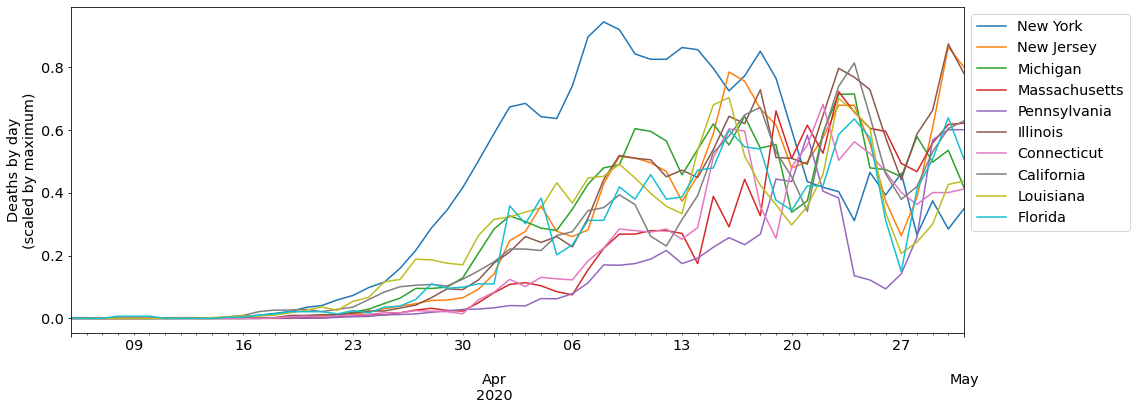

In [7]:
fig , ax = plt.subplots(figsize= (16,6))
ax = deaths_by_day.divide(deaths_by_day.max(axis = 0), axis = 1).rolling(3,).mean().loc['2020-03-05':].plot(ax = ax)
leg = ax.get_legend()
leg.set_bbox_to_anchor( (1, 1), )
ax.set_ylabel("Deaths by day\n(scaled by maximum)")

## Estimate infection time-series for each state

In [9]:
## Parameters
trans_period = (1,8)
smooth_penalty = 10.
draws = 1000
chains = 4

## Set up directories for storing ouput
time = datetime.datetime.isoformat(datetime.datetime.now() ).split(".")[0]
models_dir = os.path.join( "models", str(time) )
preds_dir = os.path.join( "predictions", str(time) )

os.makedirs(models_dir , exist_ok = True)
os.makedirs(preds_dir, exist_ok = True)

## Do estimation and write results
for state in state_top_cas:
    print("Working on {}".format(state))
    policy_dates = [x for x in policies[state].drop("Emergency Declaration").dropna().unique() ]

    ide = infection_estimator.Infect_Date_Estimator(event_series= deaths_by_day[state].copy(), 
                                                    like_func = ro_utils.make_infect_to_death_pmf(), 
                                                    trans_period = trans_period ,
                                                    policy_dates = policy_dates )
    p_i_given_obsCas, p_i, N_cas_by_day = ide.est_infect_dates( smooth_penalty = smooth_penalty,flex_factor= 0.01, draws = draws, chains = chains )
    p_i_samples =  ide.samples_p_i
    Ro = ide.Ro
    Ro_samples = ide.samples_Ro
    
    df_samples = pd.concat( [p_i_samples ,Ro_samples], axis = 1, keys = ["p_i", "Ro"] )
    df_samples.to_csv( os.path.join(preds_dir , "{}_samples.csv".format(state)) )
    df_cinterval =  pd.concat( [p_i , Ro] , axis = 1, keys = ["p_i", "Ro"] )
    df_cinterval.to_csv( os.path.join(preds_dir , "{}_intervals.csv".format(state)) )
    
    f = open(os.path.join(models_dir, "{}.pkl".format(state)) , 'wb' )
    pickle.dump(ide , f)
    f.close()
    
##  Combine results
df_samples_list = [ pd.read_csv( os.path.join(preds_dir,"{}_samples.csv".format(state)), index_col=0 , header = [0,1] ) 
                                    for state in list(state_top_cas )  ]
df_samples = pd.concat(df_samples_list, axis = 1, keys = list(state_top_cas ) )
df_samples.index = pd.to_datetime(df_samples.index)
df_samples.to_csv( os.path.join(preds_dir,"samples.csv" ) )
for state in state_top_cas:
    os.remove(os.path.join(preds_dir,"{}_samples.csv".format(state)) )
    
df_cintervals_list = [ pd.read_csv( os.path.join(preds_dir,"{}_intervals.csv".format(state)), index_col=0 , header = [0,1] ) 
                                    for state in list(state_top_cas )  ]
df_cintervals = pd.concat(df_cintervals_list, axis = 1, keys = list(state_top_cas) )
df_cintervals.to_csv(os.path.join(preds_dir,"intervals.csv" ) )
df_cintervals.index = pd.to_datetime(df_cintervals.index)
for state in state_top_cas:
    os.remove(os.path.join(preds_dir,"{}_intervals.csv".format(state)) )

Working on New York


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [theta]
Sampling chain 3, 0 divergences: 100%|██████████| 1500/1500 [00:22<00:00, 65.75it/s]


Working on New Jersey


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [theta]
Sampling chain 3, 0 divergences: 100%|██████████| 1500/1500 [00:20<00:00, 72.47it/s]


Working on Michigan


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [theta]
Sampling chain 3, 0 divergences: 100%|██████████| 1500/1500 [00:19<00:00, 78.30it/s]


Working on Massachusetts


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [theta]
Sampling chain 3, 0 divergences: 100%|██████████| 1500/1500 [00:18<00:00, 80.85it/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


Working on Pennsylvania


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [theta]
Sampling chain 3, 0 divergences: 100%|██████████| 1500/1500 [00:19<00:00, 77.66it/s]


Working on Illinois


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [theta]
Sampling chain 3, 0 divergences: 100%|██████████| 1500/1500 [00:18<00:00, 79.73it/s]


Working on Connecticut


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [theta]
Sampling chain 3, 0 divergences: 100%|██████████| 1500/1500 [00:20<00:00, 73.86it/s]


Working on California


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [theta]
Sampling chain 3, 0 divergences: 100%|██████████| 1500/1500 [00:19<00:00, 78.88it/s]


Working on Louisiana


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [theta]
Sampling chain 3, 0 divergences: 100%|██████████| 1500/1500 [00:18<00:00, 81.85it/s]


Working on Florida


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [theta]
Sampling chain 3, 0 divergences: 100%|██████████| 1500/1500 [00:17<00:00, 84.50it/s]


## Check fit to deaths-by-day data

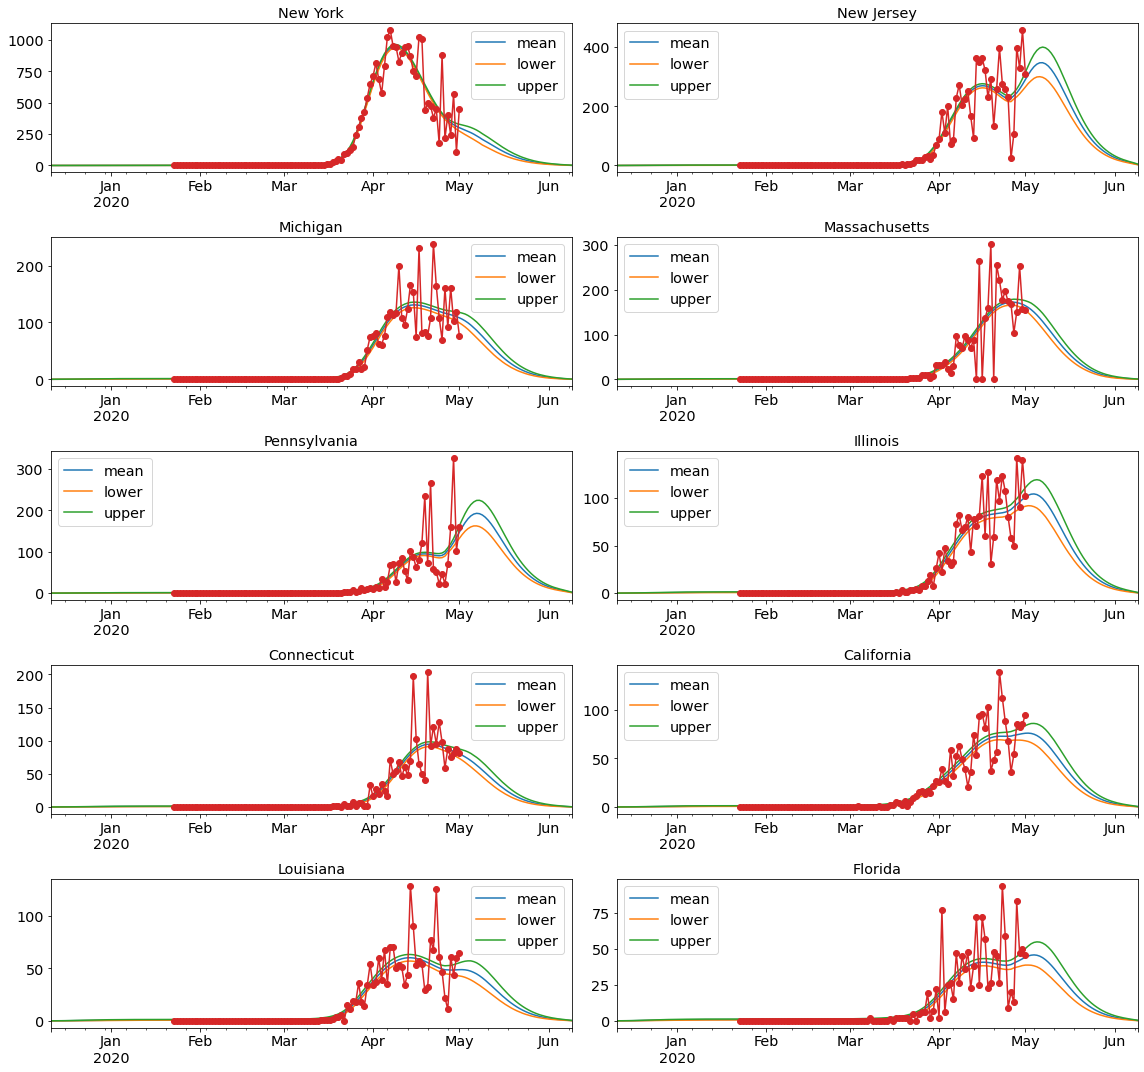

In [10]:
ncols = 2
models_dir = "./models/2020-05-02T18:53:58/"
nrows = -(-len(state_top_cas)//2)


fig , axes = plt.subplots(nrows = nrows, ncols = ncols ,figsize = (16,3*nrows))
axes = np.ravel(axes)

for state, ax in zip(state_top_cas, axes) :
    f = open( os.path.join(models_dir, "{}.pkl".format(state) ) , 'rb')
    ide = pickle.load(f)
    f.close()
    ide.N_cas_by_day.plot(ax = ax)
    deaths_by_day[state].plot(marker = "o", ax = ax)
    ax.set_title(state)
    
fig.tight_layout()

## Plot infections by day and $R_o$

In [11]:
## Load data
preditions_dir = "./predictions/2020-05-02T18:53:58/"  ## Change this to match the folder created during execution of estimation cell 
df_cintervals = pd.read_csv(os.path.join(preditions_dir, "intervals.csv"), header = [0,1,2], index_col = 0)

Text(0, 0.5, '$R_o$')

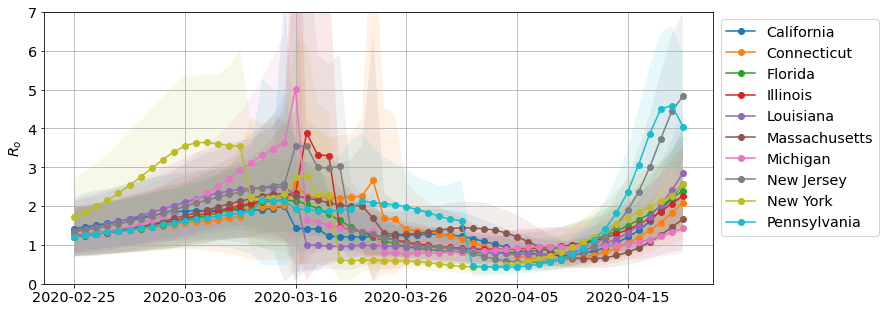

In [14]:
fig = ro_utils.plot_shaded(df_cintervals.loc[ '2020-02-25': ,(slice(None), "Ro") ].droplevel(axis = 1,level =1), alpha = 0.1)
ax = fig.get_axes()[0]
ax.set_ylim((0 , 7) )
ax.grid(True)
leg = ax.get_legend()
leg.set_bbox_to_anchor((1,1))
ax.set_ylabel(r'$R_o$')

Text(0, 0.5, 'Fraction infected on each day')

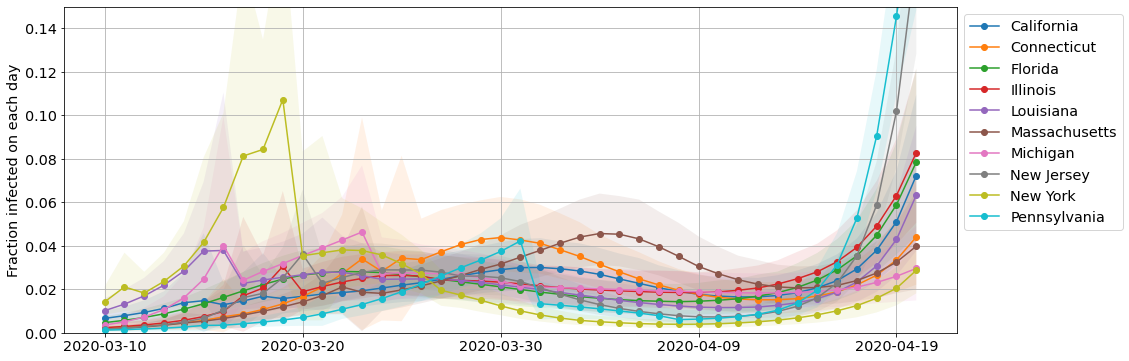

In [13]:
fig = ro_utils.plot_shaded(df_cintervals.loc[ '2020-03-10': ,(slice(None), "p_i") ].droplevel(axis = 1,level =1),
                                           alpha = 0.1,figsize = (16,6))
ax = fig.get_axes()[0]
ax.set_ylim((0 , 0.15) )
ax.grid(True)
leg = ax.get_legend()
leg.set_bbox_to_anchor((1,1))
ax.set_ylabel('Fraction infected on each day')

## Boxplot changes in $R_o$ estimated from posterior samples

In [16]:
## File names
preditions_dir = "./predictions/2020-05-02T18:53:58/" ## Change this to match the folder created during execution of estimation cell 
fname_policies = "../data/state_policy.csv"

## Load Data
df_samples = pd.read_csv( os.path.join(preditions_dir, "samples.csv"), index_col = 0, header=[0,1,2] )
df_samples.index = [pd.Timestamp(x) for x in df_samples.index]
ro_samples = df_samples.loc[ : , (slice(None), "Ro")].copy().droplevel(axis=1,  level = 1)
ro_samples_grouped = ro_samples.groupby(axis = 1, level = 0 )
policies = pd.read_csv(fname_policies ,  header =0, index_col = 0)

## Create policy_stats object
policy_stats = ro_utils.Policy_Stats(policies)
pct_change_interval, pct_change_samples = policy_stats.est_pct_change( 
                                                {state:  df.droplevel(axis =1 , level = 0) for state, df in ro_samples_grouped}, 
                                                policies =None)

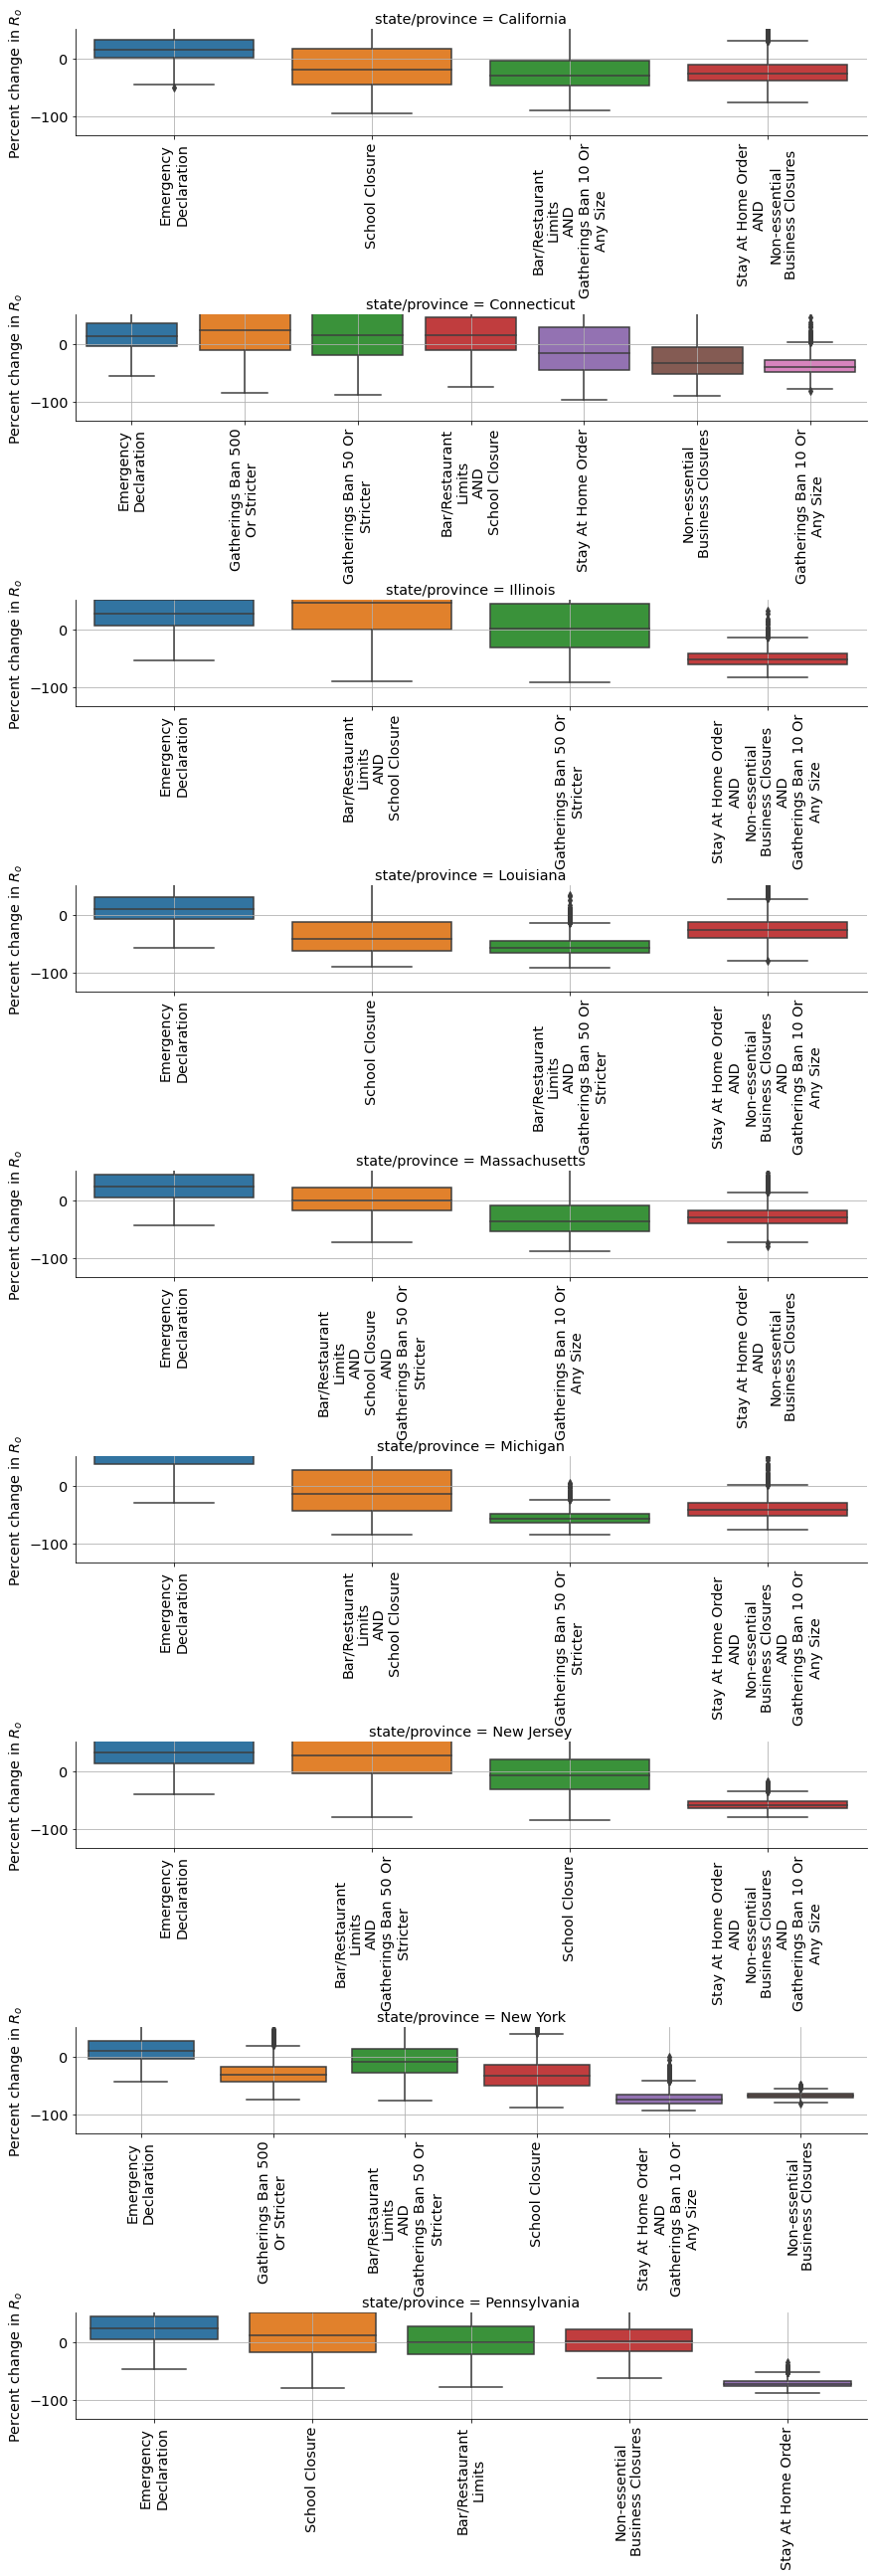

In [17]:
## Plot changes in Ro grouped by state
fig = policy_stats.boxplot_changes_by_state(policies =None, aspect = 3, height = 4, hspace=1.7)

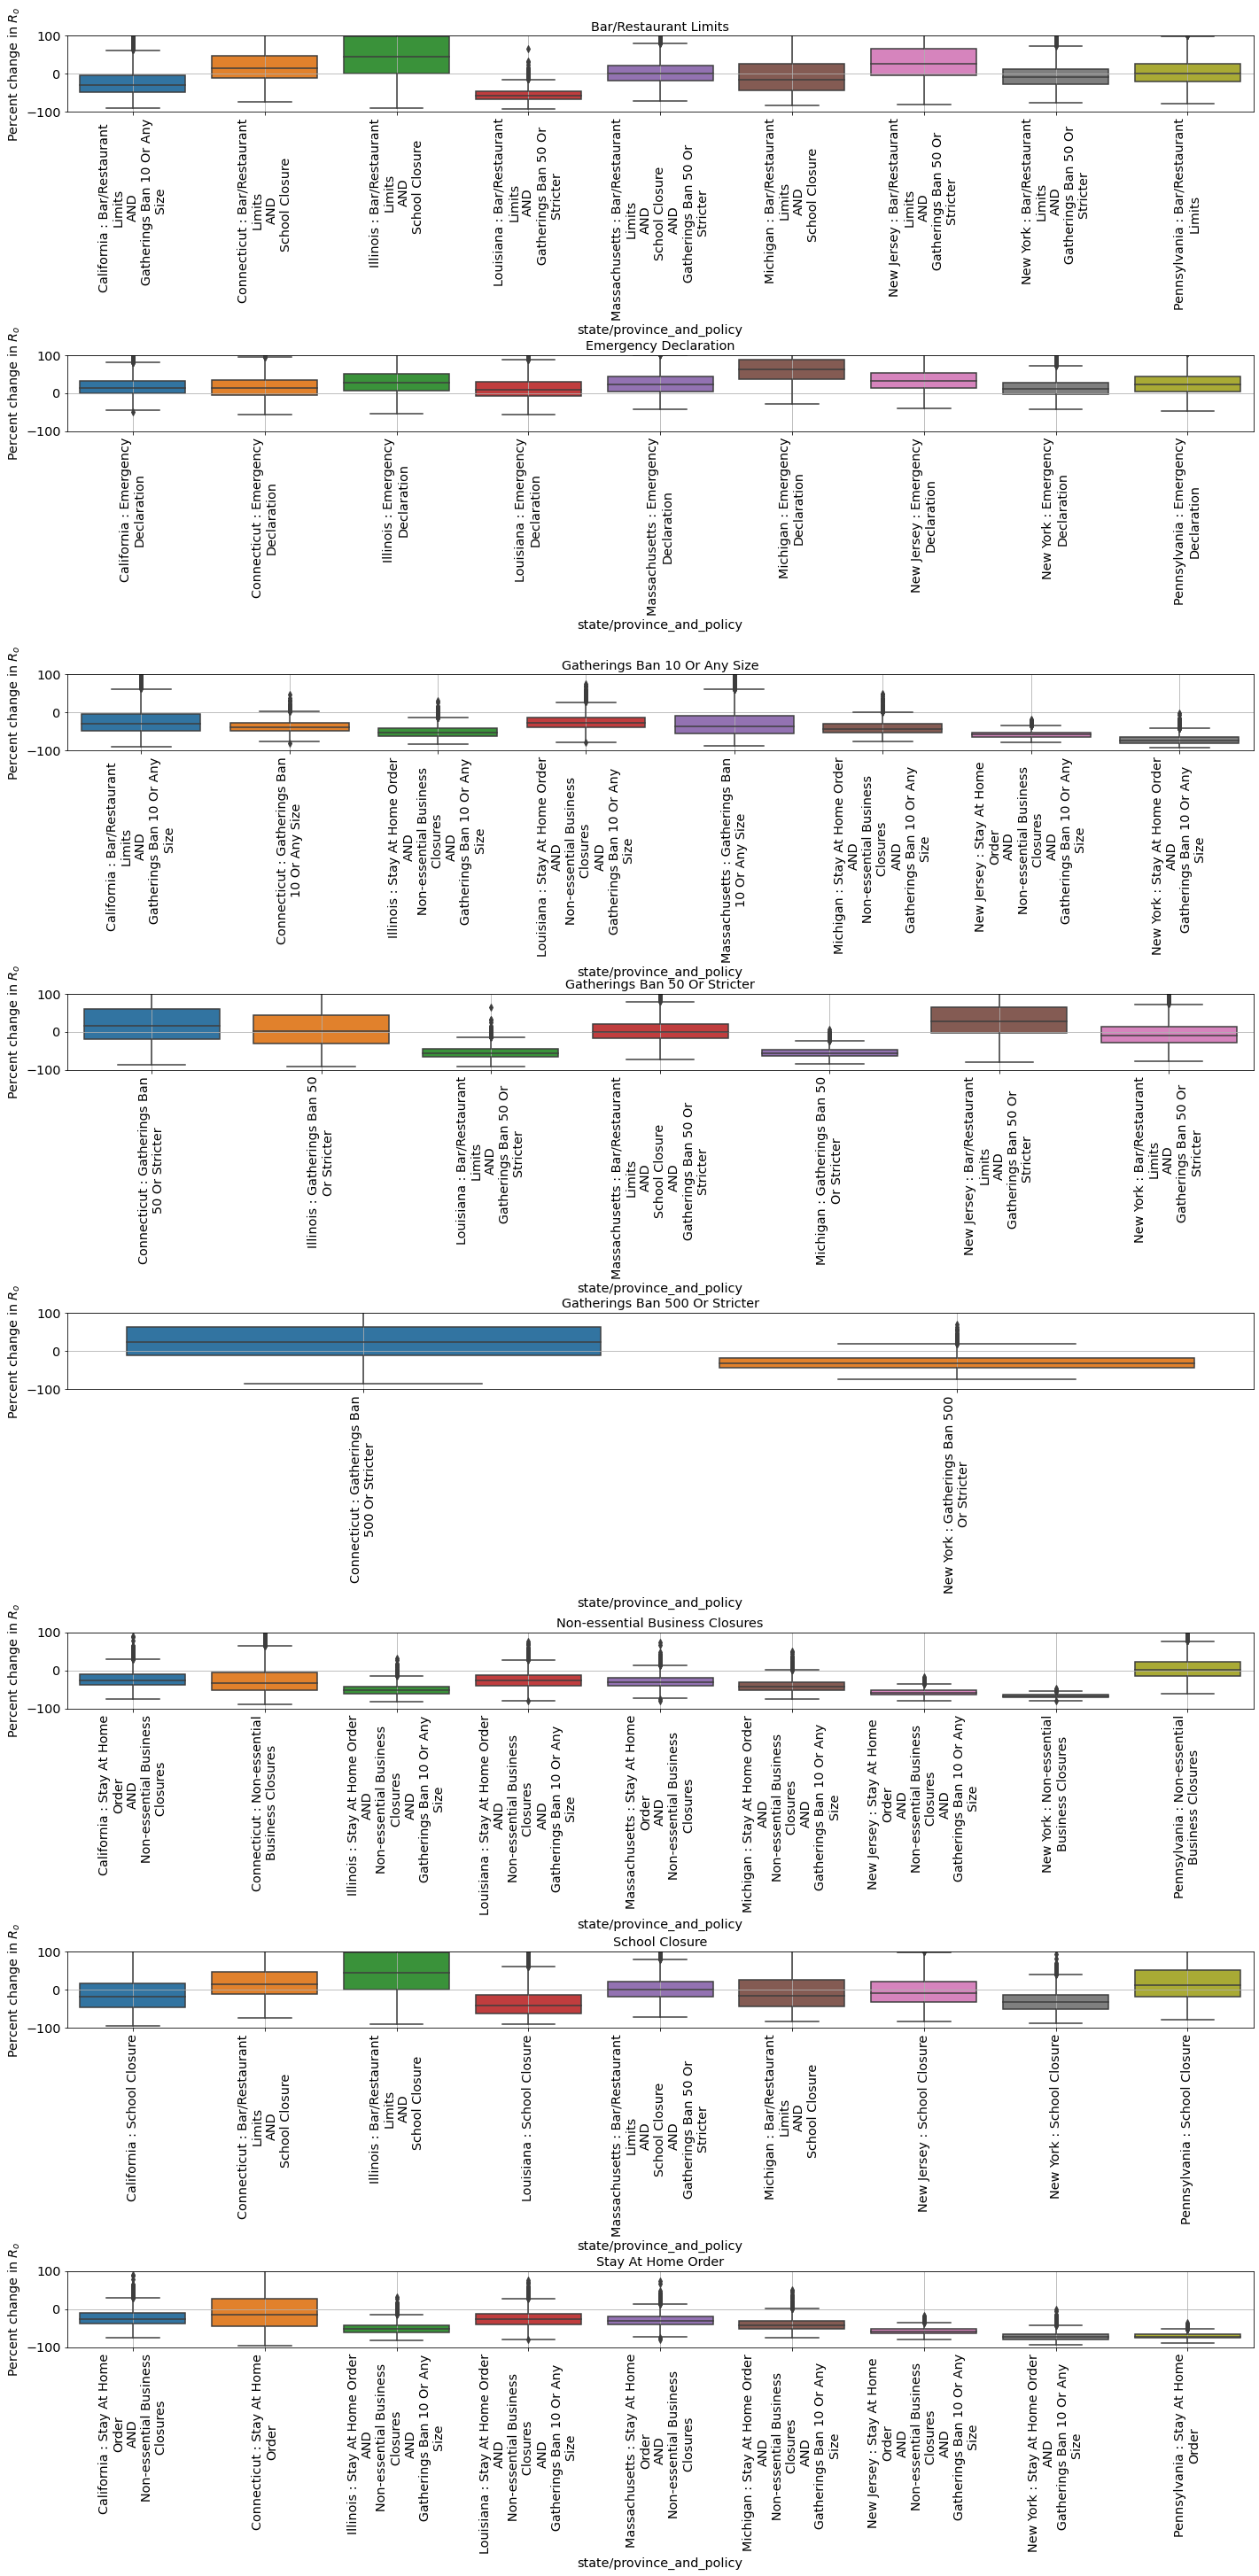

In [19]:
## Plot changes in Ro groups by policy
fig = policy_stats.boxplot_changes_by_policy(aspect = 4, height = 6,y_lim = (-100, 100), hspace = 3.2)

## Below is scratch

In [15]:
from datetime import timedelta

In [16]:
def est_Ro_fc(samples,  date, days_before=7, days_after = 7, stat = "median"):
    """
    samples - samples of p_i obtained from posterior distribution.
    """
    
    range_before = [ date + timedelta(days=d) for d in range(-1*days_before , 0) ]
    range_after = [ date + timedelta(days=d) for d in range(0, days_after) ]
    
    if stat.lower() == "median":
        ro_fc_samples = np.log2(samples.loc[range_after, :].median(axis = 0)) - \
                            np.log2(samples.loc[range_before, :].median(axis = 0) )
    elif stat.lower() == "mean":
        ro_fc_samples = np.log2(samples.loc[range_after, :].mean(axis = 0)) - \
                            np.log2(samples.loc[range_before, :].mean(axis = 0) )
    
    return ro_fc_samples
        
def est_Ro_pct_change(samples,  date, days_before=7, days_after = 7, stat = "median"):
    """
    samples - samples of p_i obtained from posterior distribution.
    """
    
    range_before = [ date + timedelta(days=d) for d in range(-1*days_before , 0) ]
    range_after = [ date + timedelta(days=d) for d in range(0, days_after) ]
    
    if stat.lower() == "median":
        ro_pct_change_samples = (samples.loc[range_after, :].median(axis = 0) - samples.loc[range_before, :].median(axis = 0)
                            ).divide( samples.loc[range_before, :].median(axis = 0))*100.
    elif stat.lower() == "mean":
        ro_pct_change_samples = (samples.loc[range_after, :].mean(axis = 0) - samples.loc[range_before, :].mean(axis = 0)
                            ).divide( samples.loc[range_before, :].mean(axis = 0))*100.
    
    return ro_pct_change_samples